<a href="https://colab.research.google.com/github/Mario-RJunior/olist-e-commerce/blob/master/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentação de Clientes

## 1) Introdução

Neste trabalho iremos analisar a base de dados disponibilizada online pela Olist.

Esta base refere-se ao desenvolvimento do comércio eletrônico no Brasil nos últimos anos, apresentando informações tanto das compras realizadas, quanto dos clientes que as fizeram, dos vendedores envolvidos e dos produtos comercializado neste tempo.

Nosso objetivo é explorar esta base de dados para tirar informações relevantes para serem utilizadas nos negócios, culminando com uma segmentação dos clientes, onde estes possam ser classificados de acordo com sua assiduidade às compras online.

## 2) Preparação dos dados

In [26]:
! pip install squarify

In [27]:
# Importando as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import squarify
import warnings
warnings.filterwarnings('ignore')

In [ ]:
! git clone https://github.com/Mario-RJunior/olist-e-commerce

Cloning into 'olist-e-commerce'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 112 (delta 60), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (112/112), 19.02 MiB | 6.43 MiB/s, done.
Resolving deltas: 100% (60/60), done.


### 2.1) Gerando o dataframe

Para gerar um dataframe, iremos carregar os arquivos ***.csv*** de forma independente e depois iremos juntá-los uns aos outros através das chaves correspondentes.

In [ ]:
# Carregando os datasets
customer = pd.read_csv('olist-e-commerce/datasets/olist_customers_dataset.csv')
orders = pd.read_csv('olist-e-commerce/datasets/olist_orders_dataset.csv')
orders_items = pd.read_csv('olist-e-commerce/datasets/olist_order_items_dataset.csv')

In [ ]:
# Junção dos dataframes
df = pd.merge(right=orders,
             left=customer,
             on='customer_id')

df = pd.merge(right=orders_items,
             left=df,
             on='order_id')

In [ ]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [ ]:
print(f'Número de linhas: {df.shape[0]} \nNúmero de colunas: {df.shape[1]}')

Número de linhas: 112650 
Número de colunas: 18


### 2.2) Verificando a consistência dos dados

Para utilizar nosso dataframe da forma ideal, precisamos inicialmente ter certeza que os dados estão consistentes, ou seja, no formato ideal, que não há valores faltantes na tabela, etc. Checaremos essas condições a seguir.

In [ ]:
# Convertendo a coluna "order_purchase_timestamp" para o formato datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

In [ ]:
# Confirmando os tipos dos dados de cada coluna
df.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
dtype: object

In [ ]:
# Verificando os valores nulos
df.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
dtype: int64

## 3) Modelo RFM

O modelo RFM é largamente utilizado para segmentação de clientes, levando em consideração as respectivas características:

- ***Recência (Recency)***: total de dias em que o cliente não realiza uma compra.
- ***Frequência (Frequency)***: número total de compras que o cliente já realizou.
- ***Monetaridade (Monetary)***: gasto total do cliente.

Iremos então descobrir cada uma dessas variáveis a partir do dataframe obtido acima.

### 3.1) Selecionando as colunas

Agora, criaremos dataframes específicos para cada uma das três variáveis de interesse para o modelo RFM. Para isso, excluiremos algumas colunas do dataframe original, deixando apenas as features que são mais relevantes para cada caso.

- ***Recência (R)***

In [ ]:
# Criando o dataframe df_r para recência
df_r = df.drop(columns=['order_id', 'customer_id', 'product_id',
                        'customer_zip_code_prefix', 'customer_city', 
                        'customer_state', 'order_status', 'order_approved_at', 
                        'order_delivered_carrier_date', 
                        'order_delivered_customer_date',
                        'order_estimated_delivery_date', 'order_item_id', 
                        'seller_id', 'shipping_limit_date',
                        'freight_value', 'price'])

In [ ]:
df_r.isnull().sum()

customer_unique_id          0
order_purchase_timestamp    0
dtype: int64

Como agora, para essas colunas não há valores nulos podemos partir diretamente para a análise.

In [ ]:
# Criando uma data de referência
data_referencia = df_r['order_purchase_timestamp'].max() + timedelta(days=1)
print(f'Data de referência: {data_referencia}')

Data de referência: 2018-09-04 09:06:57


In [ ]:
df_r = df_r.groupby(['customer_unique_id']).agg({'order_purchase_timestamp': lambda x: (data_referencia - x.max()).days})

In [ ]:
df_r.reset_index(inplace=True)
df_r.rename(columns={'order_purchase_timestamp': 'recency'}, inplace=True)

In [ ]:
df_r.head()

,customer_unique_id,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119
2,0000f46a3911fa3c0805444483337064,542
3,0000f6ccb0745a6a4b88665a16c9f078,326
4,0004aac84e0df4da2b147fca70cf8255,293


- ***Frequência (F)***

In [ ]:
# Criando o dataframe df_f para frequência
df_f = df.drop(columns=['order_purchase_timestamp', 'customer_id', 'product_id',
                        'customer_zip_code_prefix', 'customer_city', 
                        'customer_state', 'order_status', 'order_approved_at', 
                        'order_delivered_carrier_date', 
                        'order_delivered_customer_date',
                        'order_estimated_delivery_date', 'order_item_id', 
                        'seller_id', 'shipping_limit_date',
                        'freight_value', 'price'])

In [ ]:
df_f = df_f.groupby('customer_unique_id').count()

In [ ]:
df_f.rename(columns={'order_id': 'frequency'}, inplace=True)
df_f.reset_index(inplace=True)
df_f.head()

,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


- ***Monetaridade (M)***

In [ ]:
# Criando o dataframe df_m para monetaridade
df_m = df.drop(columns=['order_id', 'order_purchase_timestamp', 'customer_id', 
                        'product_id', 'customer_zip_code_prefix', 
                        'customer_city', 'customer_state', 'order_status', 
                        'order_approved_at', 'order_delivered_carrier_date', 
                        'order_delivered_customer_date',
                        'order_estimated_delivery_date', 'order_item_id', 
                        'seller_id', 'shipping_limit_date',
                        'freight_value'])

In [ ]:
df_m = df_m.groupby('customer_unique_id').sum()

In [ ]:
df_m.rename(columns={'price': 'monetary'}, inplace=True)
df_m.reset_index(inplace=True)
df_m.head()

,customer_unique_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00


### 3.2) Juntando os dataframes em um

Podemos agora obter um novo dataframe contendo os três dataframes gerados anteriormente.

In [ ]:
dados1 = {'customer_unique_id': df_r['customer_unique_id'],
         'recency': df_r['recency'],
         'frequency': df_f['frequency'],
         'monetary': df_m['monetary']
          }
df_temp = pd.DataFrame(dados1)

In [ ]:
df_temp.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00


### 3.3) Definindo a quantidade ideal de grupos

Para atingirmos nosso objetivo, precisamos organizar os clientes com características semelhantes em grupos e classificá-los através de um label específico referente a tais grupos e para isso, precisamos encontrar o número ideal de agrupamentos de acordo com nossos dados. Portanto, para tal informação urilizaremos uma técnica denominada *Elbow Method*. 

Aplicaremos então o *Elbow Method* em dois casos possíveis: 
 - Nos dados originais do dataframe df_temp.
 - Com os respectivos dados devidamente escalonados.
 
Este teste visa compreender o comportamento dos dados em ambas as abordagem para definir se há significância entre uma ou outra.

#### 3.3.1) Valores originais

In [54]:
# Utilizando o K-Means para definir o número de agrupamentos
def define_clusters(df, column):
  wcss = []
  X = df.iloc[:, [column]].values
  for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
  return wcss

In [55]:
wcss_r = define_clusters(df_temp, 1)
wcss_f = define_clusters(df_temp, 2)
wcss_m = define_clusters(df_temp, 3)

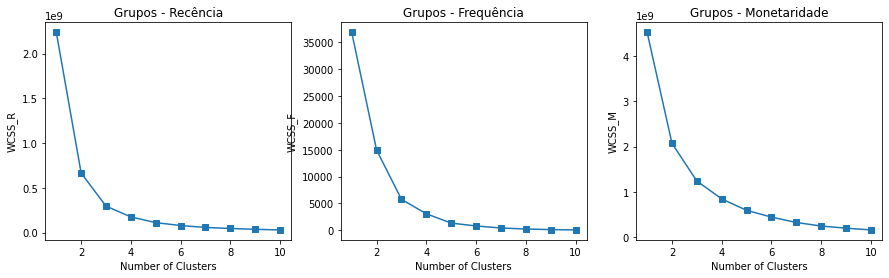

In [56]:
# Plotando os gráficos para cada dataframe
plt.figure(figsize=(15,4))

# Distribuição da recência
plt.subplot(1,3,1)
plt.plot(range(1, 11), wcss_r, marker='s')
plt.title('Grupos - Recência')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_R')

# Distribuição da frequência
plt.subplot(1,3,2)
plt.plot(range(1, 11), wcss_f, marker='s')
plt.title('Grupos - Frequência')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_F')

# Distribuição da monetaridade
plt.subplot(1,3,3)
plt.plot(range(1, 11), wcss_m, marker='s')
plt.title('Grupos - Monetaridade')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_M')

plt.show()

#### 3.3.2) Valores escalonados

Iremos agora repetir o processo feito em (3.3.1) com os respectivos valores escalonados.

In [33]:
# Criando o scaler
scaler = StandardScaler()

In [74]:
# Separando as variáveis de df_temp para serem escalonadas

# Variável recency
X_R = df_temp.iloc[:, [1]].values

# Variável frequency
X_F = df_temp.iloc[:, [2]].values

# Variável monetary
X_M = df_temp.iloc[:, [3]].values

In [40]:
# Escalonando as variáveis X_R, X_F, X_M
X_RE = scaler.fit_transform(X_R)
X_FE = scaler.fit_transform(X_F)
X_ME = scaler.fit_transform(X_M)

In [75]:
# Utilizando o K-Means para definir o número de agrupamentos
def define_clusters_scaled(var):
  wcss = []
  for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(var)
    wcss.append(kmeans.inertia_)
  return wcss

In [62]:
wcss_re = define_clusters_scaled(X_RE)
wcss_fe = define_clusters_scaled(X_FE)
wcss_me = define_clusters_scaled(X_ME)

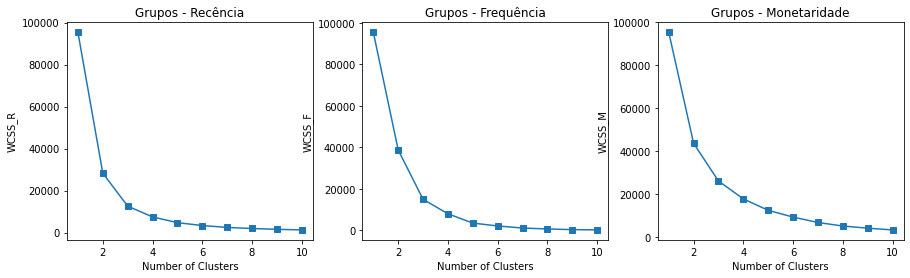

In [65]:
# Plotando os gráficos para as variáveis escalonadas
plt.figure(figsize=(15,4))

# Distribuição da recência
plt.subplot(1,3,1)
plt.plot(range(1, 11), wcss_re, marker='s')
plt.title('Grupos - Recência')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_R')

# Distribuição da frequência
plt.subplot(1,3,2)
plt.plot(range(1, 11), wcss_fe, marker='s')
plt.title('Grupos - Frequência')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_F')

# Distribuição da monetaridade
plt.subplot(1,3,3)
plt.plot(range(1, 11), wcss_me, marker='s')
plt.title('Grupos - Monetaridade')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_M')

plt.show()

Note que pelos gráficos obtidos na partes (3.3.1) e (3.3.2) obtivemos resultados similares, e portanto para este caso o escalonamento das variáveis é opcional, sendo então possível utilizar ambas as abordagens. Por isso, consideraremos cinco clusters como a quantidade ideal. 

### 3.4) Fazendo o treinamento via K-Means

Definido então a quantidade de 5 clusteres como o ideal, podemos fazer o treinamento dos dados da maneira como segue. Além disso, de acordo com o resultado obtido criaremos labels referentes a cada grupo.

In [68]:
# Considerando portanto 5 clusters
def cluster_clients(df, column):
  X = df.iloc[:, [column]].values
  kmeans = KMeans(n_clusters=5, random_state=0)
  previsoes = kmeans.fit_predict(X)
  return previsoes

In [69]:
# Criando os labels para cada dataframe
label_r = cluster_clients(df_temp, 1)
label_f = cluster_clients(df_temp, 2)
label_m = cluster_clients(df_temp, 3)

In [70]:
# Criação de uma coluna com os labels
df_temp['R'] = label_r
df_temp['F'] = label_f
df_temp['M'] = label_m

In [72]:
# Alterando a ordem das colunas de forma apropriada
columnsTitles = ['customer_unique_id', 
                 'recency', 'R', 
                 'frequency', 'F', 
                 'monetary', 'M']

df_temp = df_temp.reindex(columns=columnsTitles)

In [76]:
df_temp.head()

,customer_unique_id,recency,R,frequency,F,monetary,M
0,0000366f3b9a7992bf8c76cfdf3221e2,116,0,1,0,129.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,0,1,0,18.90,0
2,0000f46a3911fa3c0805444483337064,542,1,1,0,69.00,0
3,0000f6ccb0745a6a4b88665a16c9f078,326,2,1,0,25.99,0
4,0004aac84e0df4da2b147fca70cf8255,293,2,1,0,180.00,4


### 3.5) Rearranjando os índices dos labels

Um importante ajuste que necessita-se fazer agora é redefinir os labels R, F, M para que eles possam associar a cada grupo um grau de importância, atribuindo-se assim um "peso" para cada cluster. Neste ponto, podemos utilizar a seguinte referência:

- Recência: quanto maior, pior. Ordem de importância: 4, 3, 2, 1, 0.
- Frequência: quanto maior, melhor. Ordem de importância: 0, 1, 2, 3, 4.
- Monetaridade: quanto maior, melhor. Ordem de importância: 0, 1, 2, 3, 4.

In [82]:
df_temp.groupby('R').mean().sort_values(by='recency', ascending=False).reset_index()['R']

0    1
1    4
2    2
3    0
4    3
Name: R, dtype: int64

In [85]:
df_temp.groupby('F').mean().sort_values(by='recency', ascending=True).reset_index()['F']

0    4
1    3
2    1
3    2
4    0
Name: F, dtype: int64

In [86]:
df_temp.groupby('M').mean().sort_values(by='monetary', ascending=True).reset_index()['M']

0    0
1    4
2    1
3    3
4    2
Name: M, dtype: int64

Assim, os labels precisam ser alterados da forma:

- R: 0 -> 3; 1 -> 0; 2 -> 2; 3 -> 4; 4 -> 1.
- F: 0 -> 4; 1 -> 2; 2 -> 3; 3 -> 1; 4 -> 0.
- M: 0 -> 0; 1 -> 2; 2 -> 4; 3 -> 3; 4 -> 1.

Podemos realizar este ajusta mediante uma função.

In [87]:
def adjust_index(df, column, label, ascend):
  x = df.groupby(label).mean().sort_values(by=column, ascending=ascend).reset_index()
  index = tuple(zip(x.index, x[label].values))
  for c in index:
    df.loc[df[label] == c[1], f'adjusted_{label}'] = c[0] 
  df[f'adjusted_{label}'] = df[f'adjusted_{label}'].apply(lambda x: int(x))
  return df

In [88]:
df_temp = adjust_index(df_temp, 'recency', 'R', False)
df_temp = adjust_index(df_temp, 'frequency', 'F', True)
df_temp = adjust_index(df_temp, 'monetary', 'M', True)

In [90]:
# Alterando a ordem das colunas de forma apropriada
columnsTitles = ['customer_unique_id', 
                 'recency', 'R', 'adjusted_R' ,
                 'frequency', 'F', 'adjusted_F',
                 'monetary', 'M', 'adjusted_M']

df_temp = df_temp.reindex(columns=columnsTitles)

### 3.6) Criando o dataframe final

Finalmente, podemos agora criar o dataframe final com os dados obtidos nos passos anteriores.

In [92]:
# Excluindo as colunas R, F, M e renomeando as colunas adjusted_R, adjusted_F, adjusted_M
df_final = df_temp.drop(columns=['R', 'F', 'M'])

In [97]:
df_final.rename(columns={'adjusted_R': 'R',
                         'adjusted_F': 'F',
                         'adjusted_M': 'M'}, inplace=True)

In [98]:
# Criando uma coluna com a pontuação final de cada cliente
df_final['score'] = df_final['R'] + df_final['F'] + df_final['M']
df_final.head()

,customer_unique_id,recency,R,frequency,F,monetary,M,score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,3,1,0,129.90,0,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,3,1,0,18.90,0,3
2,0000f46a3911fa3c0805444483337064,542,0,1,0,69.00,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,326,2,1,0,25.99,0,2
4,0004aac84e0df4da2b147fca70cf8255,293,2,1,0,180.00,1,3


## 4) Agrupando os clientes

Agora podemos fazer um agrupamento dos clientes considerando as variáveis recência, frequência e monetaridade duas a duas, obtendo assim três gráficos relacionando os clientes a cada uma das variáveis.

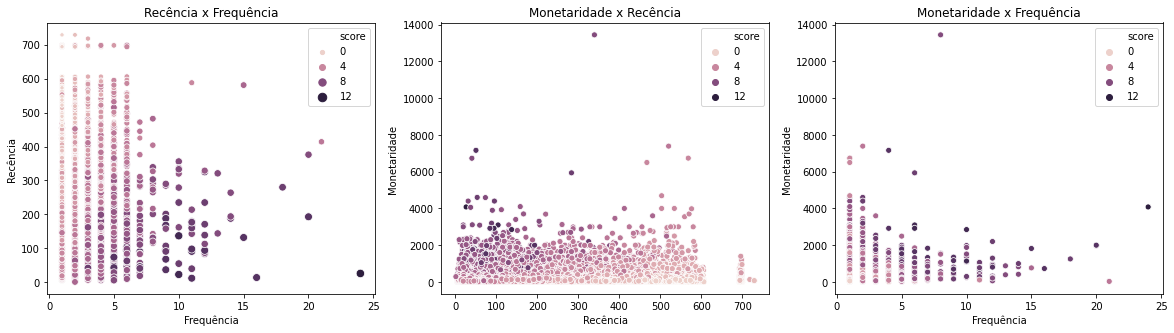

In [134]:
# Plotando os gráficos
plt.figure(figsize=(20,5))

# Recência x Frequência
plt.subplot(1,3,1)
sns.scatterplot(data=df_final, 
                x='frequency', 
                y='recency', 
                hue='score', 
                size='score',)
plt.title('Recência x Frequência')
plt.xlabel('Frequência')
plt.ylabel('Recência')

# Monetaridade x Recência
plt.subplot(1,3,2)
sns.scatterplot(data=df_final, 
                x='recency', 
                y='monetary', 
                hue='score')

plt.title('Monetaridade x Recência')
plt.xlabel('Recência')
plt.ylabel('Monetaridade')

# Monetaridade x Frequência
plt.subplot(1,3,3)
sns.scatterplot(data=df_final, x='frequency', y='monetary', hue='score')
plt.title('Monetaridade x Frequência')
plt.xlabel('Frequência')
plt.ylabel('Monetaridade')

plt.show()

### 4.3) Criação do modelo de Agrupamento

Passaremos agora para a criação do modelo usando o K-Means.

In [ ]:
# Modelo para Recência x Frequência
kmeans_rf = KMeans(n_clusters=5, random_state=0)
previsoes_rf = kmeans_rf.fit_predict(X_RF)

# Modelo para Recência x Monetaridade
kmeans_rm = KMeans(n_clusters=5, random_state=0)
previsoes_rm = kmeans_rm.fit_predict(X_RM)

# Modelo para Frequência x Monetaridade
kmeans_fm = KMeans(n_clusters=5, random_state=0)
previsoes_fm = kmeans_fm.fit_predict(X_FM)

### 4.4) Gráficos

### 4.4.1) Recência x Frequência

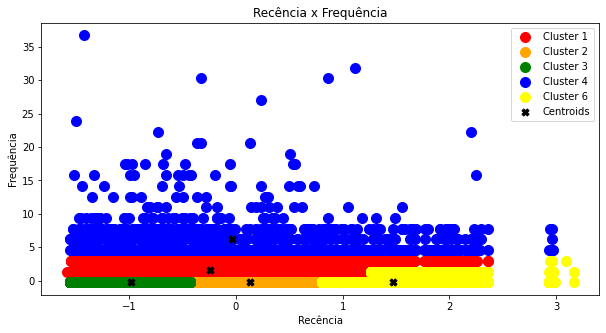

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.scatter(X_RF[previsoes_rf == 0, 0], X_RF[previsoes_rf == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(X_RF[previsoes_rf == 1, 0], X_RF[previsoes_rf == 1, 1], s=100, c='orange', label='Cluster 2')
plt.scatter(X_RF[previsoes_rf == 2, 0], X_RF[previsoes_rf == 2, 1], s=100, c='green', label='Cluster 3')
plt.scatter(X_RF[previsoes_rf == 3, 0], X_RF[previsoes_rf == 3, 1], s=100, c='blue', label='Cluster 4')
plt.scatter(X_RF[previsoes_rf == 4, 0], X_RF[previsoes_rf == 4, 1], s=100, c='yellow', label='Cluster 6')
plt.scatter(kmeans_rf.cluster_centers_[:,0], kmeans_rf.cluster_centers_[:,1], s=50, marker='X', c='black', label='Centroids')
plt.title('Recência x Frequência')
plt.xlabel('Recência')
plt.ylabel('Frequência')
plt.legend()
plt.show()

### 4.4.2) Recência x Monetaridade

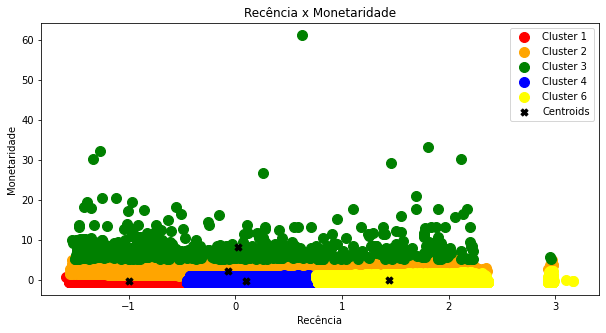

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.scatter(X_RM[previsoes_rm == 0, 0], X_RM[previsoes_rm == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(X_RM[previsoes_rm == 1, 0], X_RM[previsoes_rm == 1, 1], s=100, c='orange', label='Cluster 2')
plt.scatter(X_RM[previsoes_rm == 2, 0], X_RM[previsoes_rm == 2, 1], s=100, c='green', label='Cluster 3')
plt.scatter(X_RM[previsoes_rm == 3, 0], X_RM[previsoes_rm == 3, 1], s=100, c='blue', label='Cluster 4')
plt.scatter(X_RM[previsoes_rm == 4, 0], X_RM[previsoes_rm == 4, 1], s=100, c='yellow', label='Cluster 6')
plt.scatter(kmeans_rm.cluster_centers_[:,0], kmeans_rm.cluster_centers_[:,1], s=50, marker='X', c='black', label='Centroids')
plt.title('Recência x Monetaridade')
plt.xlabel('Recência')
plt.ylabel('Monetaridade')
plt.legend()
plt.show()

### 4.4.3) Frequência x Monetaridade

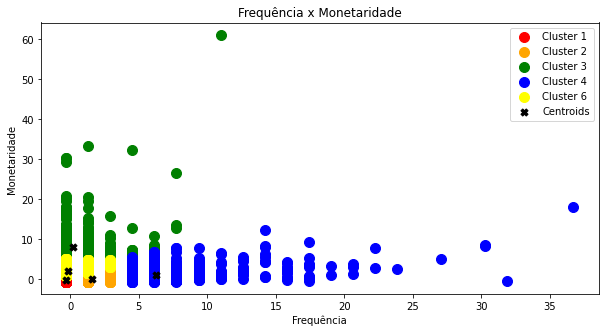

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.scatter(X_FM[previsoes_fm == 0, 0], X_FM[previsoes_fm == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(X_FM[previsoes_fm == 1, 0], X_FM[previsoes_fm == 1, 1], s=100, c='orange', label='Cluster 2')
plt.scatter(X_FM[previsoes_fm == 2, 0], X_FM[previsoes_fm == 2, 1], s=100, c='green', label='Cluster 3')
plt.scatter(X_FM[previsoes_fm == 3, 0], X_FM[previsoes_fm == 3, 1], s=100, c='blue', label='Cluster 4')
plt.scatter(X_FM[previsoes_fm == 4, 0], X_FM[previsoes_fm == 4, 1], s=100, c='yellow', label='Cluster 6')
plt.scatter(kmeans_fm.cluster_centers_[:,0], kmeans_fm.cluster_centers_[:,1], s=50, marker='X', c='black', label='Centroids')
plt.title('Frequência x Monetaridade')
plt.xlabel('Frequência')
plt.ylabel('Monetaridade')
plt.legend()
plt.show()

### 4.4.4) Agrupamento geral

#### 4.4.4.1) Adicionando uma coluna de score

Podemos agora adicionar ao dataframe df_final uma coluna contabilizando o score final de cada cliente. Neste caso, apenas somaremos o conteúdo das colunas R, F, M para gerar sua pontuação final.

In [ ]:
# Adicionando o score final
df_final['score'] = df_final['R'] + df_final['F'] + df_final['M']

In [ ]:
df_final.head()

,customer_unique_id,recency,R,frequency,F,monetary,M,score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,3,1,0,129.90,0,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,3,1,0,18.90,0,3
2,0000f46a3911fa3c0805444483337064,542,0,1,0,69.00,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,1,0,25.99,0,1
4,0004aac84e0df4da2b147fca70cf8255,293,1,1,0,180.00,0,1


In [ ]:
df_final.tail()

,customer_unique_id,recency,R,frequency,F,monetary,M,score
95415,fffcf5a5ff07b0908bd4e2dbc735a684,452,0,2,1,1570.00,3,4
95416,fffea47cd6d3cc0a88bd621562a9d061,267,1,1,0,64.89,0,1
95417,ffff371b4d645b6ecea244b27531430a,573,0,1,0,89.90,0,0
95418,ffff5962728ec6157033ef9805bacc48,124,3,1,0,115.00,0,3
95419,ffffd2657e2aad2907e67c3e9daecbeb,489,0,1,0,56.99,0,0


In [ ]:
print(f'Score mínimo: {df_final["score"].min()} \nScore máximo: {df_final["score"].max()}')

Score mínimo: 0 
Score máximo: 9


### 4.4.4.2) Criação dos labels para classificação

In [ ]:
def rfm_classification(df):
  if df['score'] <= 1:
    return 'Ruim'
  elif df['score'] <= 3:
    return 'Regular'
  elif df['score'] <= 4:
    return 'Bom'
  elif df['score'] <= 5:
    return 'Muito bom'
  else:
    return 'Ótimo'

In [ ]:
# Criação de uma nova coluna RMF_leve
df_final['RFM_level'] = df_final.apply(rfm_classification, axis=1)

In [ ]:
df_final.head()

,customer_unique_id,recency,R,frequency,F,monetary,M,score,RFM_level
0,0000366f3b9a7992bf8c76cfdf3221e2,116,3,1,0,129.90,0,3,Regular
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,3,1,0,18.90,0,3,Regular
2,0000f46a3911fa3c0805444483337064,542,0,1,0,69.00,0,0,Ruim
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,1,0,25.99,0,1,Ruim
4,0004aac84e0df4da2b147fca70cf8255,293,1,1,0,180.00,0,1,Ruim


In [ ]:
# Cálculo dos valores médios para RMF_level
rfm_level_agg = df_final.groupby('RFM_level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
})

In [ ]:
rfm_level_agg

recency frequency     monetary       
                 mean      mean         mean  count
RFM_level                                          
Bom        110.545191  1.639199   311.095227   6893
Muito bom   99.812045  2.248179   565.148499   2059
Regular    168.347233  1.136714   128.292987  52233
Ruim       398.916714  1.038019    88.239042  33667
Ótimo       93.727113  4.227113  1077.028345    568

In [ ]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']

#### 4.4.4.3) Plotando o diagrama

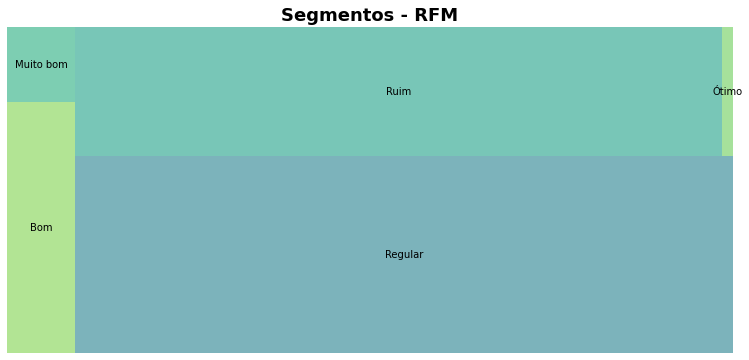

In [ ]:
# Plotando o respectivo diagrama
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(13,6)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Bom',
                     'Muito bom',
                     'Regular',
                     'Ruim',                                          
                     'Ótimo',
                     ], alpha=.6 )
plt.title("Segmentos - RFM",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()